In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
# logistic regression
from sklearn.linear_model import LogisticRegression
# support vector machine
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# classification report
from sklearn.metrics import classification_report

df_sample1 = pd.read_csv('data_ml/SharedResponses_sample1.csv')
df_sample2 = pd.read_csv('data_ml/SharedResponses_sample2.csv')

df_combined = pd.read_csv('data_ml/SharedResponses_combined_two_genders.csv')
df_female = pd.read_csv('data_ml/SharedResponses_female.csv')
df_male = pd.read_csv('data_ml/SharedResponses_male.csv')

In [2]:
df_list = [df_sample1, df_sample2, df_combined, df_female, df_male]

for df in df_list:
    df.dropna(inplace=True)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1029 entries, 0 to 1231
Data columns (total 44 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ResponseID               1029 non-null   object 
 1   ExtendedSessionID        1029 non-null   object 
 2   UserID                   1029 non-null   int64  
 3   ScenarioOrder            1029 non-null   int64  
 4   Intervention             1029 non-null   int64  
 5   PedPed                   1029 non-null   int64  
 6   Barrier                  1029 non-null   int64  
 7   CrossingSignal           1029 non-null   int64  
 8   AttributeLevel           1029 non-null   object 
 9   ScenarioTypeStrict       1029 non-null   object 
 10  ScenarioType             1029 non-null   object 
 11  DefaultChoice            1029 non-null   object 
 12  NonDefaultChoice         1029 non-null   object 
 13  DefaultChoiceIsOmission  1029 non-null   float64
 14  NumberOfCharacters       1029

In [3]:
import shap
from sklearn.ensemble import RandomForestClassifier

df_x_combined_with_political = df_combined.iloc[:, 3:-2]
df_x_combined_without_political = df_combined.iloc[:, 3:-3]

df_x_combined_with_political = df_x_combined_with_political.drop(['Saved'], axis=1)
df_x_combined_without_political = df_x_combined_without_political.drop(['Saved'], axis=1)

df_x_combined_with_political = df_x_combined_with_political.apply(lambda x: pd.to_numeric(x, errors='coerce'))
df_x_combined_without_political = df_x_combined_without_political.apply(lambda x: pd.to_numeric(x, errors='coerce'))

df_x_combined_with_political = df_x_combined_with_political.replace([float('inf'), float('-inf')], float('nan'))
df_x_combined_without_political = df_x_combined_without_political.replace([float('inf'), float('-inf')], float('nan'))

df_x_combined_with_political = df_x_combined_with_political.apply(lambda x: x.clip(lower=-1e10, upper=1e10))
df_x_combined_without_political = df_x_combined_without_political.apply(lambda x: x.clip(lower=-1e10, upper=1e10))

df_x_combined_with_political = df_x_combined_with_political.dropna(axis=1)
df_x_combined_without_political = df_x_combined_without_political.dropna(axis=1)

x_train_with_political, x_test_with_political, y_train_with_political, y_test_with_political = train_test_split(df_x_combined_with_political, df_combined['Saved'], test_size=0.2, random_state=0)
x_train_without_political, x_test_without_political, y_train_without_political, y_test_without_political = train_test_split(df_x_combined_without_political, df_combined['Saved'], test_size=0.2, random_state=0)

rf_model_with_political = RandomForestClassifier()
rf_model_without_political = RandomForestClassifier()

rf_model_with_political.fit(x_train_with_political, y_train_with_political)
rf_model_without_political.fit(x_train_without_political, y_train_without_political)

RandomForestClassifier()

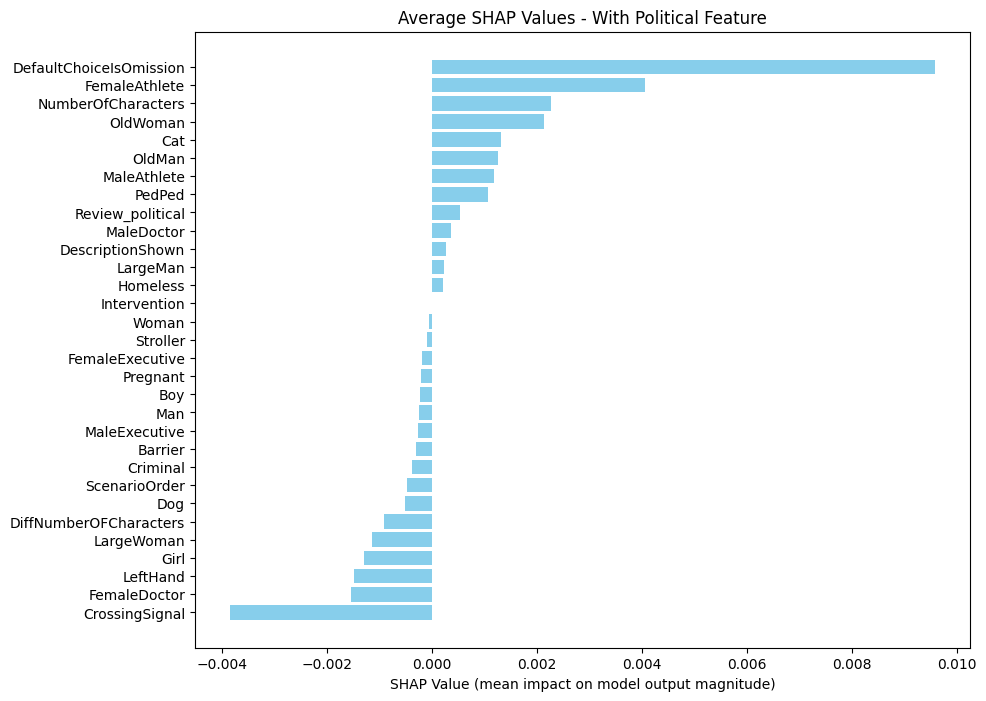

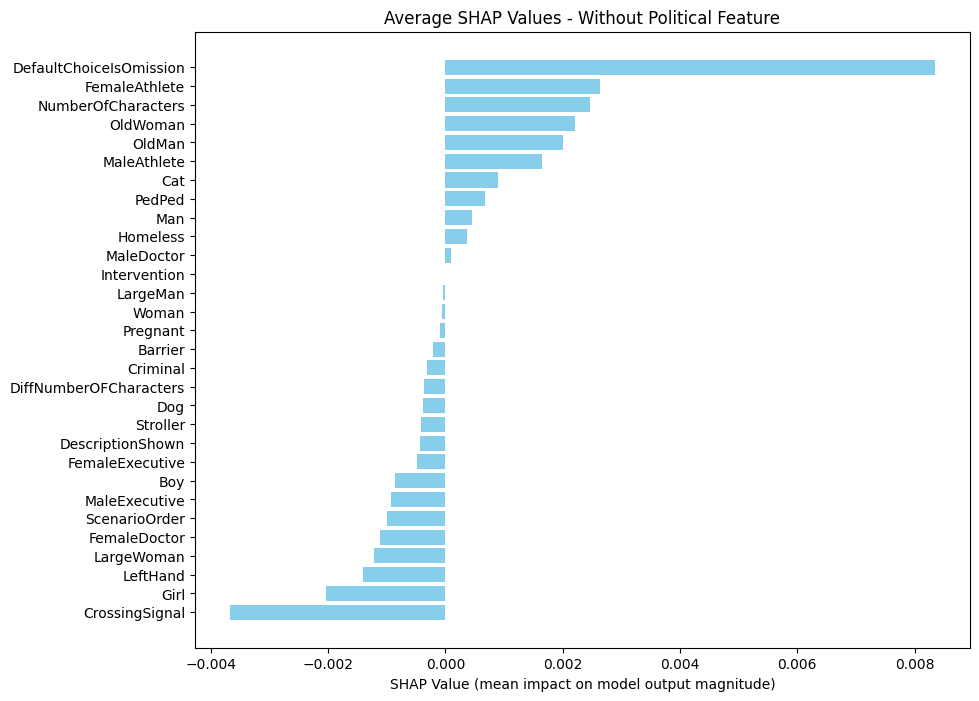

In [6]:
import numpy as np
import matplotlib.pyplot as plt


explainer_with_political = shap.TreeExplainer(rf_model_with_political)
explainer_without_political = shap.TreeExplainer(rf_model_without_political)


# Define a function to calculate SHAP values for multiple iterations and take the average
def calculate_average_shap_values(model, X_test, explainer, iterations=20):
    all_shap_values = []
    for _ in range(iterations):
        shap_values = explainer.shap_values(X_test)
        # Assuming binary classification and interest in the positive class (index 1)
        all_shap_values.append(shap_values[1])
    
    # Convert to NumPy array for easy mean calculation
    all_shap_values_array = np.array(all_shap_values)
    # Calculate the mean across all iterations for each feature
    average_shap_values = np.mean(all_shap_values_array, axis=0)
    
    return average_shap_values

# Calculate average SHAP values for each model
average_shap_values_with_political = calculate_average_shap_values(rf_model_with_political, x_test_with_political, explainer_with_political)
average_shap_values_without_political = calculate_average_shap_values(rf_model_without_political, x_test_without_political, explainer_without_political)

# Function to plot the average SHAP values as a bar graph
def plot_average_shap_values(average_shap_values, feature_names, title):
    mean_shap_values = np.mean(average_shap_values, axis=0)
    sorted_feature_indices = np.argsort(mean_shap_values)
    
    plt.figure(figsize=(10, 8))
    plt.title(title)
    plt.barh(range(len(feature_names)), mean_shap_values[sorted_feature_indices], color='skyblue')
    plt.yticks(range(len(feature_names)), np.array(feature_names)[sorted_feature_indices])
    plt.xlabel("SHAP Value (mean impact on model output magnitude)")
    plt.show()

# Plotting the SHAP values
plot_average_shap_values(average_shap_values_with_political, x_test_with_political.columns, "Average SHAP Values - With Political Feature")
plot_average_shap_values(average_shap_values_without_political, x_test_without_political.columns, "Average SHAP Values - Without Political Feature")


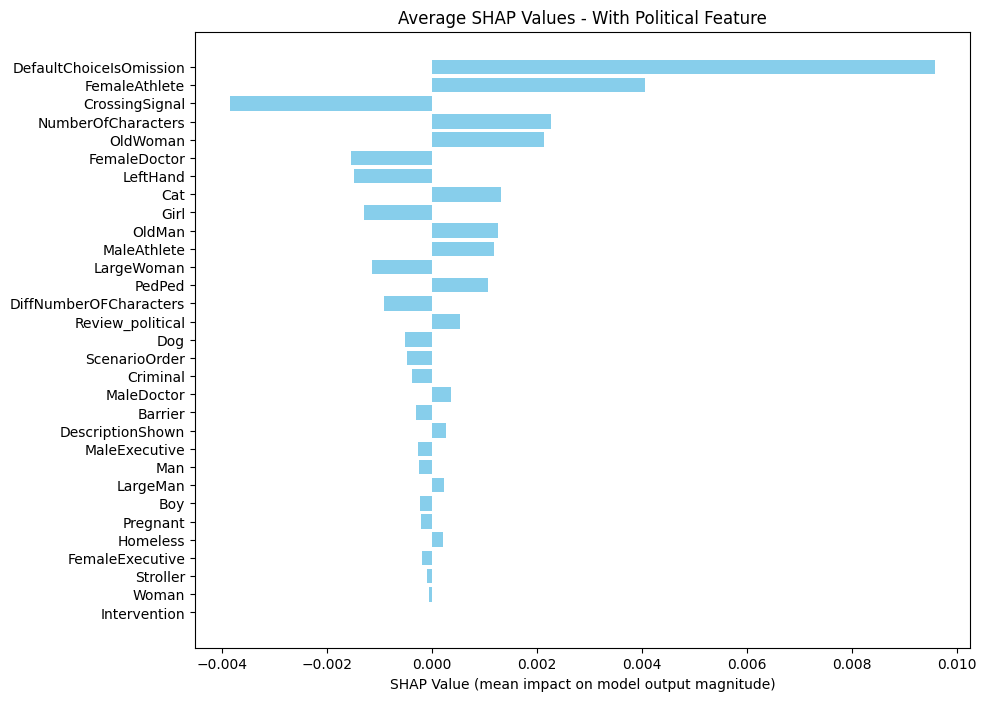

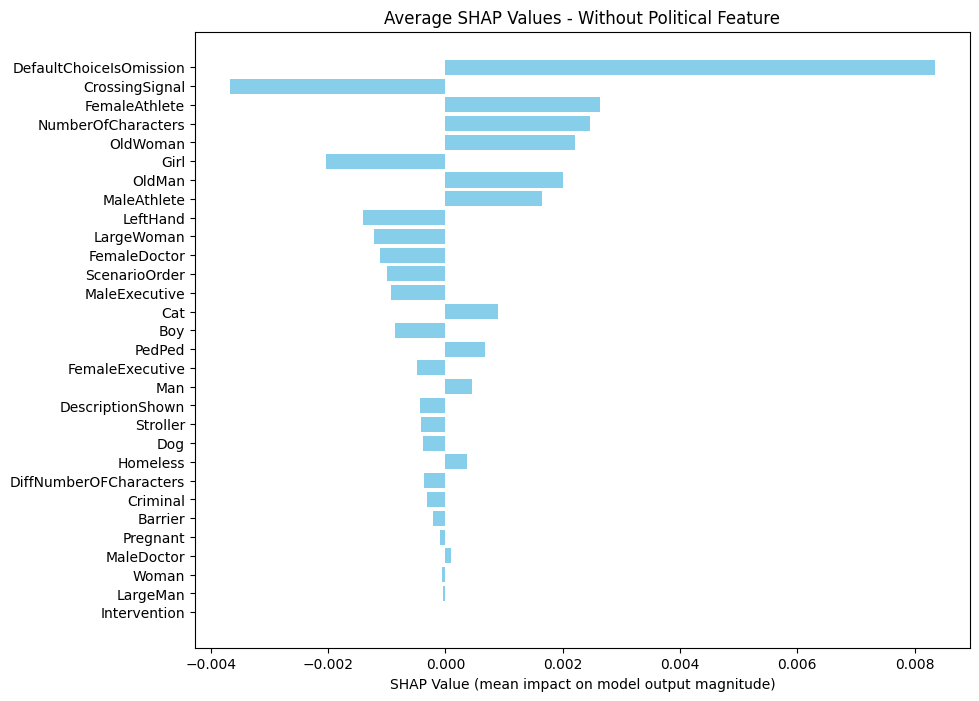

In [8]:
# plot the absolute value of the SHAP values from largest to smallest

def plot_average_shap_values_absolute(average_shap_values, feature_names, title):
    mean_shap_values = np.mean(average_shap_values, axis=0)
    sorted_feature_indices = np.argsort(np.abs(mean_shap_values))
    
    plt.figure(figsize=(10, 8))
    plt.title(title)
    plt.barh(range(len(feature_names)), mean_shap_values[sorted_feature_indices], color='skyblue')
    plt.yticks(range(len(feature_names)), np.array(feature_names)[sorted_feature_indices])
    plt.xlabel("SHAP Value (mean impact on model output magnitude)")
    plt.show()

# Plotting the SHAP values
plot_average_shap_values_absolute(average_shap_values_with_political, x_test_with_political.columns, "Average SHAP Values - With Political Feature")
plot_average_shap_values_absolute(average_shap_values_without_political, x_test_without_political.columns, "Average SHAP Values - Without Political Feature")

In [17]:
# sort the features based on the absolute SHAP values from largest to smallest
sorted_feature_indices_with_political = np.argsort(np.abs(np.mean(average_shap_values_with_political, axis=0)))

sorted_feature_indices_with_political = np.argsort(np.abs(np.mean(average_shap_values_with_political, axis=0)))
sorted_feature_indices_without_political = np.argsort(np.abs(np.mean(average_shap_values_without_political, axis=0)))

# print the top 15 features for each model based on the absolute SHAP values
# from largest to smallest
print("Top 15 features for model with political feature:")
# print from largest to smallest
for index in sorted_feature_indices_with_political[::-1][:15]:
    print(x_test_with_political.columns[index])

print("\nTop 15 features for model without political feature:")
# print from largest to smallest
for index in sorted_feature_indices_without_political[::-1][:15]:
    print(x_test_without_political.columns[index])
    





Top 15 features for model with political feature:
DefaultChoiceIsOmission
FemaleAthlete
CrossingSignal
NumberOfCharacters
OldWoman
FemaleDoctor
LeftHand
Cat
Girl
OldMan
MaleAthlete
LargeWoman
PedPed
DiffNumberOFCharacters
Review_political

Top 15 features for model without political feature:
DefaultChoiceIsOmission
CrossingSignal
FemaleAthlete
NumberOfCharacters
OldWoman
Girl
OldMan
MaleAthlete
LeftHand
LargeWoman
FemaleDoctor
ScenarioOrder
MaleExecutive
Cat
Boy


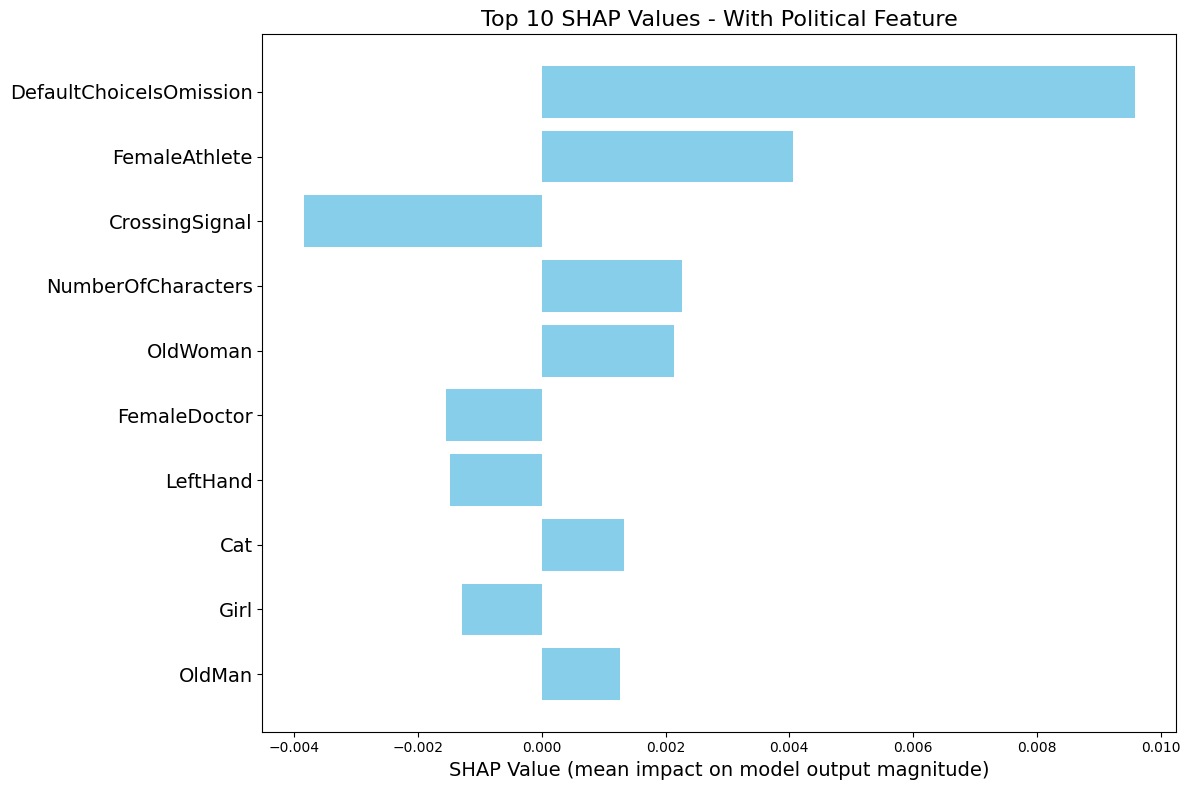

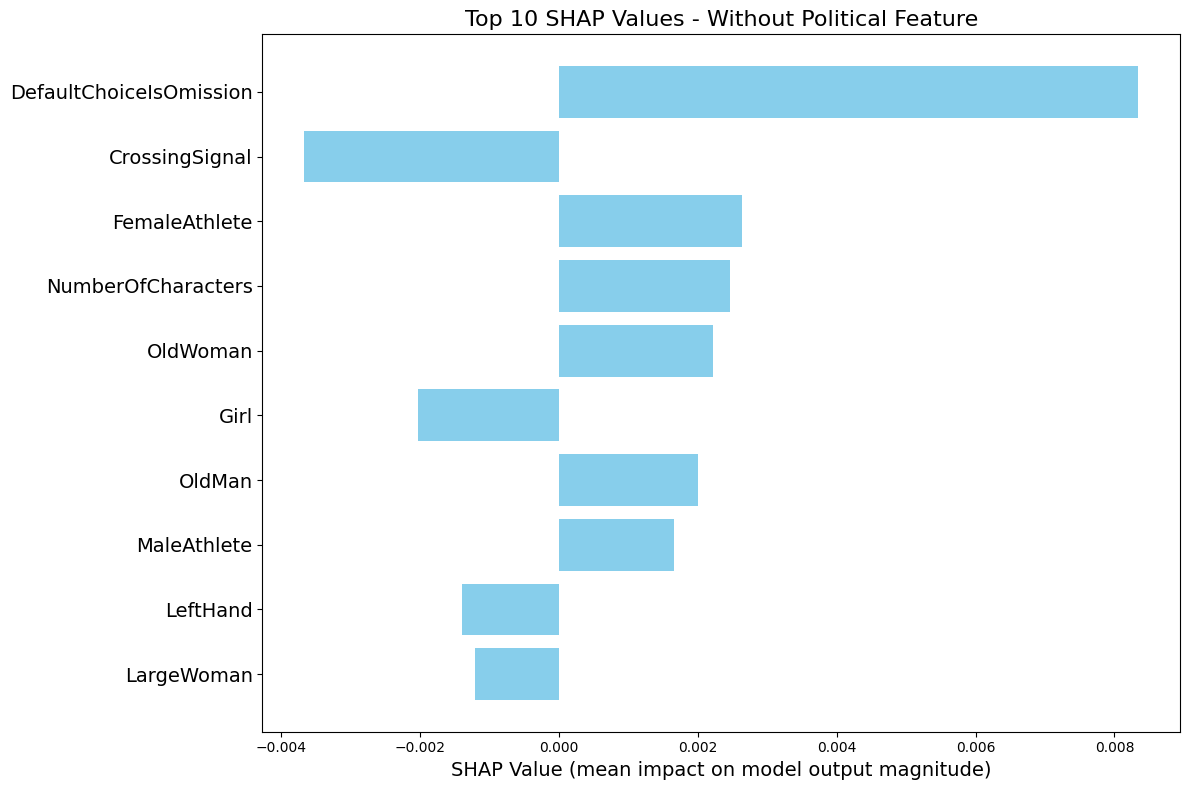

In [11]:
sorted_feature_indices_with_political = np.argsort(np.abs(np.mean(average_shap_values_with_political, axis=0)))
sorted_feature_indices_without_political = np.argsort(np.abs(np.mean(average_shap_values_without_political, axis=0)))

# Extracting the top 10 features
top_10_features_with_political = np.array(x_test_with_political.columns)[sorted_feature_indices_with_political][-10:]
top_10_features_without_political = np.array(x_test_without_political.columns)[sorted_feature_indices_without_political][-10:]

# Extracting the top 10 SHAP values
top_10_shap_values_with_political = np.mean(average_shap_values_with_political, axis=0)[sorted_feature_indices_with_political][-10:]
top_10_shap_values_without_political = np.mean(average_shap_values_without_political, axis=0)[sorted_feature_indices_without_political][-10:]

# Function to plot top 10 SHAP values with larger text sizes
def plot_top_10_shap_values(top_10_features, top_10_shap_values, title):
    plt.figure(figsize=(12, 8))
    plt.title(title, fontsize=16)
    plt.barh(range(len(top_10_features)), top_10_shap_values, color='skyblue')
    plt.yticks(range(len(top_10_features)), top_10_features, fontsize=14)
    plt.xlabel("SHAP Value (mean impact on model output magnitude)", fontsize=14)
    plt.tight_layout()  # Adjusts plot parameters to give some padding
    plt.show()

# Plotting the top 10 SHAP values for the model with political feature
plot_top_10_shap_values(top_10_features_with_political, top_10_shap_values_with_political, "Top 10 SHAP Values - With Political Feature")

# Plotting the top 10 SHAP values for the model without political feature
plot_top_10_shap_values(top_10_features_without_political, top_10_shap_values_without_political, "Top 10 SHAP Values - Without Political Feature")


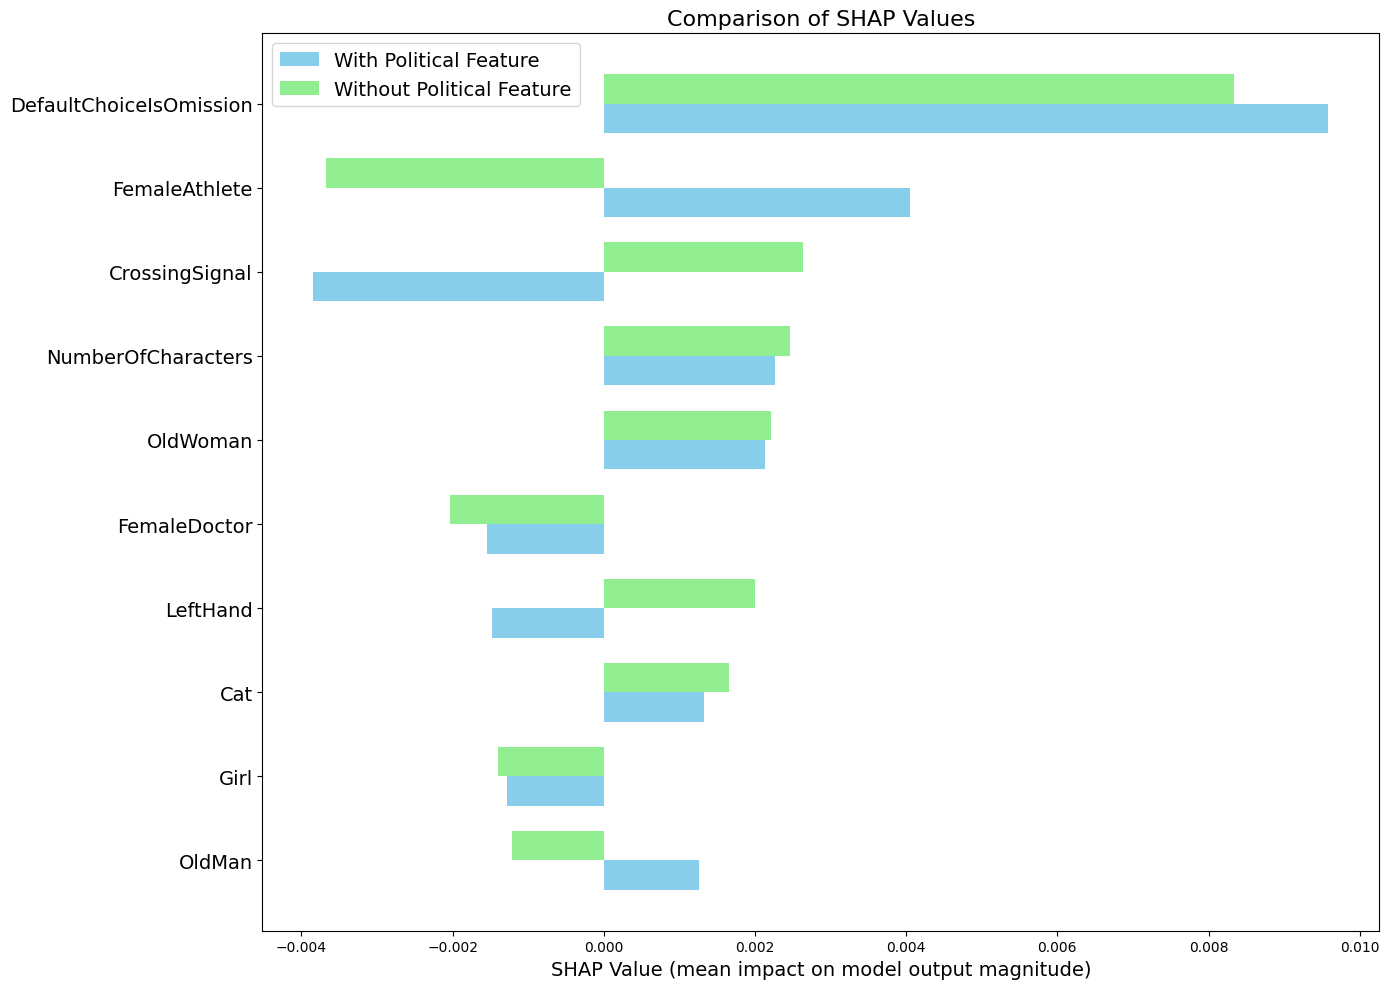

In [12]:
def plot_combined_shap_values(top_10_features_with, top_10_shap_values_with, top_10_features_without, top_10_shap_values_without, title):
    # Set up the matplotlib figure
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Set the positions and width for the bars
    index = np.arange(len(top_10_features_with))
    bar_width = 0.35
    
    # Plotting both sets of data
    bars1 = ax.barh(index - bar_width/2, top_10_shap_values_with, bar_width, label='With Political Feature', color='skyblue')
    bars2 = ax.barh(index + bar_width/2, top_10_shap_values_without, bar_width, label='Without Political Feature', color='lightgreen')
    
    # Add some text for labels, title, and axes ticks
    ax.set_xlabel('SHAP Value (mean impact on model output magnitude)', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.set_yticks(index)
    ax.set_yticklabels(top_10_features_with, fontsize=14)
    ax.legend(fontsize=14)
    
    plt.tight_layout()
    plt.show()

# Since the features might not exactly match between models, we'll focus on comparing the top 10 from either list,
# assuming that they are somewhat comparable. Adjust the approach if the features differ significantly.
plot_combined_shap_values(top_10_features_with_political, top_10_shap_values_with_political, top_10_features_without_political, top_10_shap_values_without_political, "Comparison of SHAP Values")

In [5]:


i = 1

for df in df_list:

    print('the {}th dataset'.format(i))

    df_x = df.iloc[:, 3:-2]
    df_y = df['Saved']
    df_x = df_x.drop(['Saved'], axis=1)
    df_x = df_x.apply(lambda x: pd.to_numeric(x, errors='coerce'))

    # deal with inf and -inf
    df_x = df_x.replace([float('inf'), float('-inf')], float('nan'))

    # deal with too large values
    df_x = df_x.apply(lambda x: x.clip(lower=-1e10, upper=1e10))
    df_x = df_x.dropna(axis=1)

    x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=0)

    # Random Forest
    model = RandomForestClassifier()
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print('Random Forest')
    print(accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    # Logistic Regression
    model = LogisticRegression()
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print('Logistic Regression')
    print(accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    print('--------------------------------------')
    i += 1



the 1th dataset
Random Forest
0.7092337917485265
              precision    recall  f1-score   support

           0       0.68      0.81      0.74       257
           1       0.75      0.61      0.68       252

    accuracy                           0.71       509
   macro avg       0.72      0.71      0.71       509
weighted avg       0.72      0.71      0.71       509

Logistic Regression
0.7092337917485265
              precision    recall  f1-score   support

           0       0.68      0.79      0.73       257
           1       0.75      0.62      0.68       252

    accuracy                           0.71       509
   macro avg       0.71      0.71      0.71       509
weighted avg       0.71      0.71      0.71       509

--------------------------------------
the 2th dataset
Random Forest
0.7338551859099804
              precision    recall  f1-score   support

           0       0.75      0.76      0.76       276
           1       0.71      0.70      0.71       235

    ac

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


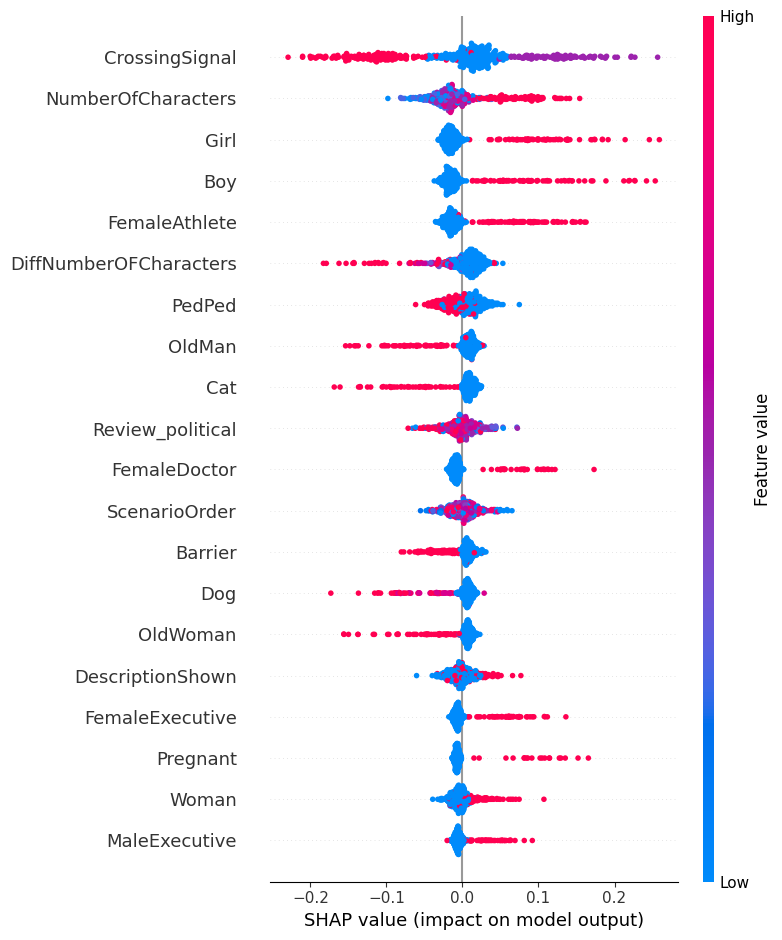

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


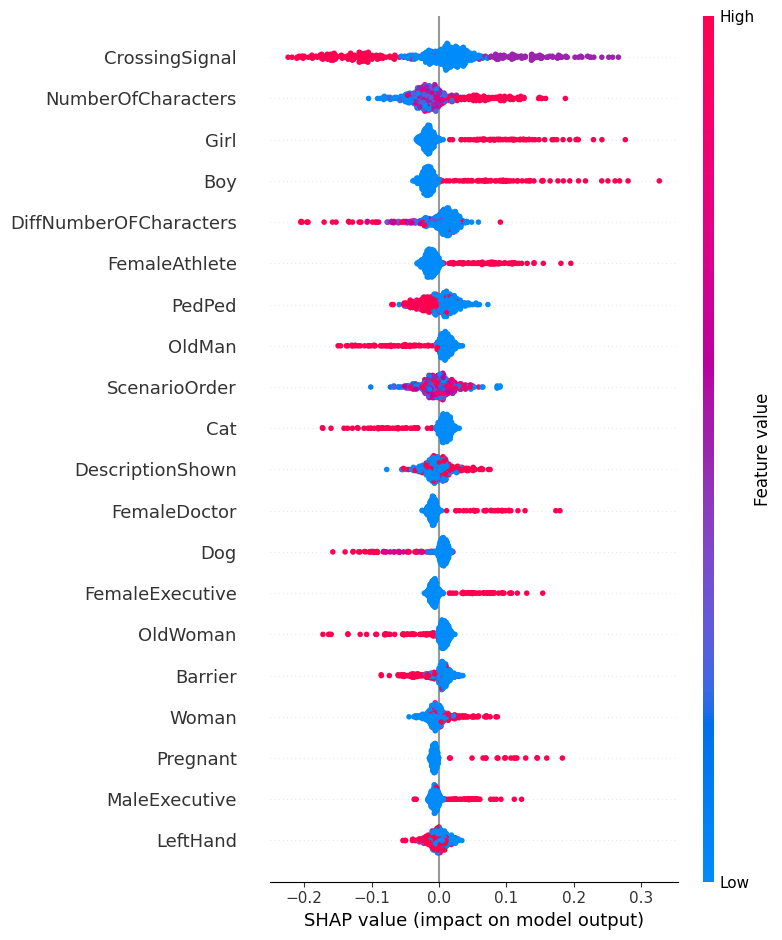

In [10]:
import shap
from sklearn.ensemble import RandomForestClassifier

df_x_combined_with_political = df_combined.iloc[:, 3:-2]
df_x_combined_without_political = df_combined.iloc[:, 3:-3]

df_x_combined_with_political = df_x_combined_with_political.drop(['Saved'], axis=1)
df_x_combined_without_political = df_x_combined_without_political.drop(['Saved'], axis=1)

df_x_combined_with_political = df_x_combined_with_political.apply(lambda x: pd.to_numeric(x, errors='coerce'))
df_x_combined_without_political = df_x_combined_without_political.apply(lambda x: pd.to_numeric(x, errors='coerce'))

df_x_combined_with_political = df_x_combined_with_political.replace([float('inf'), float('-inf')], float('nan'))
df_x_combined_without_political = df_x_combined_without_political.replace([float('inf'), float('-inf')], float('nan'))

df_x_combined_with_political = df_x_combined_with_political.apply(lambda x: x.clip(lower=-1e10, upper=1e10))
df_x_combined_without_political = df_x_combined_without_political.apply(lambda x: x.clip(lower=-1e10, upper=1e10))

df_x_combined_with_political = df_x_combined_with_political.dropna(axis=1)
df_x_combined_without_political = df_x_combined_without_political.dropna(axis=1)

x_train_with_political, x_test_with_political, y_train_with_political, y_test_with_political = train_test_split(df_x_combined_with_political, df_combined['Saved'], test_size=0.2, random_state=0)
x_train_without_political, x_test_without_political, y_train_without_political, y_test_without_political = train_test_split(df_x_combined_without_political, df_combined['Saved'], test_size=0.2, random_state=0)

rf_model_with_political = RandomForestClassifier()
rf_model_without_political = RandomForestClassifier()

rf_model_with_political.fit(x_train_with_political, y_train_with_political)
rf_model_without_political.fit(x_train_without_political, y_train_without_political)

explainer_with_political = shap.TreeExplainer(rf_model_with_political)
explainer_without_political = shap.TreeExplainer(rf_model_without_political)


# explainer = shap.Explainer(model_combined, x_train_combined)

# # Calculate SHAP values
# shap_values = explainer(x_test_combined, check_additivity=False)

# # print(type(shap_values))
# # print(shap_values.shape)

# # print(type(x_test_combined))
# # print(x_test_combined.shape)
# shap_values_positive_class = shap_values.values[...,1]

# # Now you can plot the summary plot for the positive class
# shap.summary_plot(shap_values_positive_class, x_test_combined)

shap_values_with_political = explainer_with_political.shap_values(x_test_with_political)
shap_values_without_political = explainer_without_political.shap_values(x_test_without_political)

# plot the SHAP values for the positive class
shap.summary_plot(shap_values_with_political[1], x_test_with_political)
shap.summary_plot(shap_values_without_political[1], x_test_without_political)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


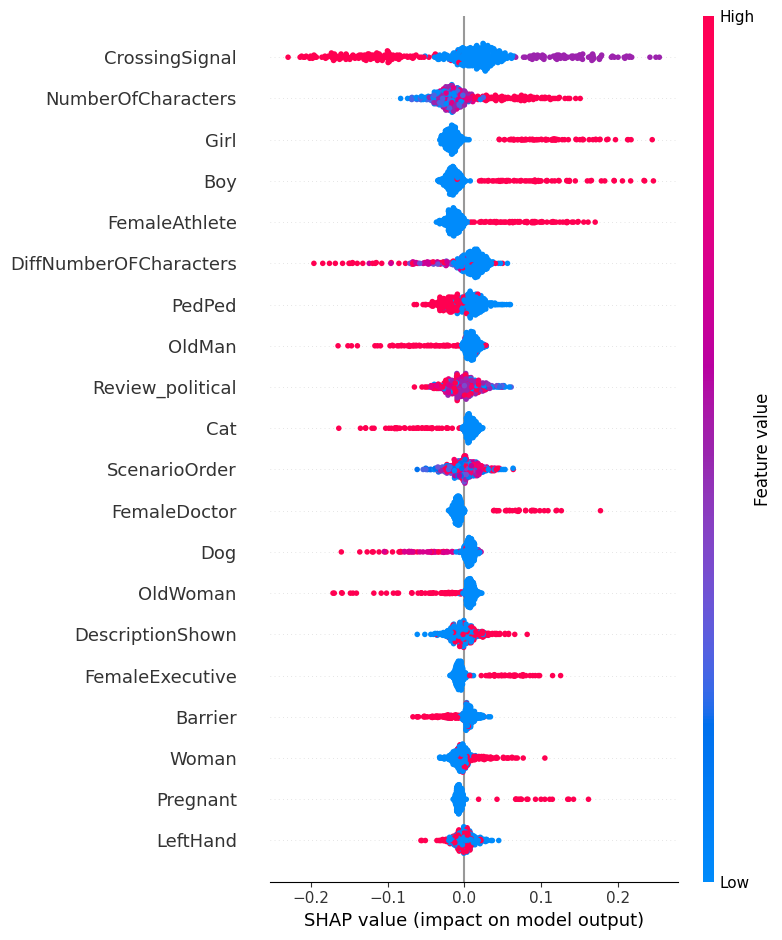

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


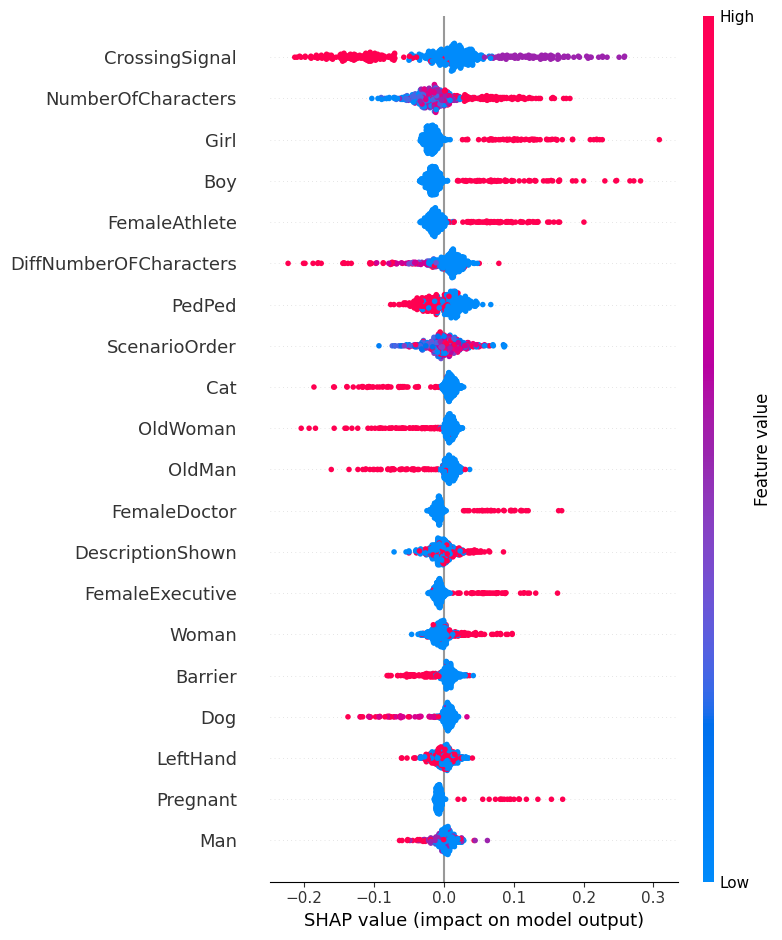

In [18]:
import shap
from sklearn.ensemble import RandomForestClassifier

df_x_combined_with_political = df_combined.iloc[:, 3:-2]
df_x_combined_without_political = df_combined.iloc[:, 3:-3]

df_x_combined_with_political = df_x_combined_with_political.drop(['Saved'], axis=1)
df_x_combined_without_political = df_x_combined_without_political.drop(['Saved'], axis=1)

df_x_combined_with_political = df_x_combined_with_political.apply(lambda x: pd.to_numeric(x, errors='coerce'))
df_x_combined_without_political = df_x_combined_without_political.apply(lambda x: pd.to_numeric(x, errors='coerce'))

df_x_combined_with_political = df_x_combined_with_political.replace([float('inf'), float('-inf')], float('nan'))
df_x_combined_without_political = df_x_combined_without_political.replace([float('inf'), float('-inf')], float('nan'))

df_x_combined_with_political = df_x_combined_with_political.apply(lambda x: x.clip(lower=-1e10, upper=1e10))
df_x_combined_without_political = df_x_combined_without_political.apply(lambda x: x.clip(lower=-1e10, upper=1e10))

df_x_combined_with_political = df_x_combined_with_political.dropna(axis=1)
df_x_combined_without_political = df_x_combined_without_political.dropna(axis=1)

x_train_with_political, x_test_with_political, y_train_with_political, y_test_with_political = train_test_split(df_x_combined_with_political, df_combined['Saved'], test_size=0.2, random_state=0)
x_train_without_political, x_test_without_political, y_train_without_political, y_test_without_political = train_test_split(df_x_combined_without_political, df_combined['Saved'], test_size=0.2, random_state=0)

rf_model_with_political = RandomForestClassifier()
rf_model_without_political = RandomForestClassifier()

rf_model_with_political.fit(x_train_with_political, y_train_with_political)
rf_model_without_political.fit(x_train_without_political, y_train_without_political)

explainer_with_political = shap.TreeExplainer(rf_model_with_political)
explainer_without_political = shap.TreeExplainer(rf_model_without_political)


# explainer = shap.Explainer(model_combined, x_train_combined)

# # Calculate SHAP values
# shap_values = explainer(x_test_combined, check_additivity=False)

# # print(type(shap_values))
# # print(shap_values.shape)

# # print(type(x_test_combined))
# # print(x_test_combined.shape)
# shap_values_positive_class = shap_values.values[...,1]

# # Now you can plot the summary plot for the positive class
# shap.summary_plot(shap_values_positive_class, x_test_combined)

shap_values_with_political = explainer_with_political.shap_values(x_test_with_political)
shap_values_without_political = explainer_without_political.shap_values(x_test_without_political)

# plot the SHAP values for the positive class
shap.summary_plot(shap_values_with_political[1], x_test_with_political)
shap.summary_plot(shap_values_without_political[1], x_test_without_political)

In [19]:
# feature importance
import pandas as pd

feature_importance_with_political = pd.DataFrame(rf_model_with_political.feature_importances_, index=x_train_with_political.columns, columns=['importance']).sort_values('importance', ascending=False)
feature_importance_without_political = pd.DataFrame(rf_model_without_political.feature_importances_, index=x_train_without_political.columns, columns=['importance']).sort_values('importance', ascending=False)

print(feature_importance_with_political)
print(feature_importance_without_political)

                        importance
ScenarioOrder             0.120564
Review_political          0.116476
NumberOfCharacters        0.073611
CrossingSignal            0.069447
DiffNumberOFCharacters    0.047759
Man                       0.035811
Woman                     0.033924
LeftHand                  0.033054
PedPed                    0.032654
DescriptionShown          0.032607
FemaleAthlete             0.028833
OldMan                    0.027813
Girl                      0.027811
MaleAthlete               0.027743
Boy                       0.027391
OldWoman                  0.025739
LargeMan                  0.024945
LargeWoman                0.021776
Cat                       0.021644
Dog                       0.020935
Barrier                   0.020390
MaleExecutive             0.019409
FemaleDoctor              0.018617
FemaleExecutive           0.018605
MaleDoctor                0.017755
Homeless                  0.016424
Pregnant                  0.014547
Criminal            

Decision Tree
0.6105476673427992
              precision    recall  f1-score   support

           0       0.63      0.65      0.64       262
           1       0.59      0.57      0.58       231

    accuracy                           0.61       493
   macro avg       0.61      0.61      0.61       493
weighted avg       0.61      0.61      0.61       493



No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


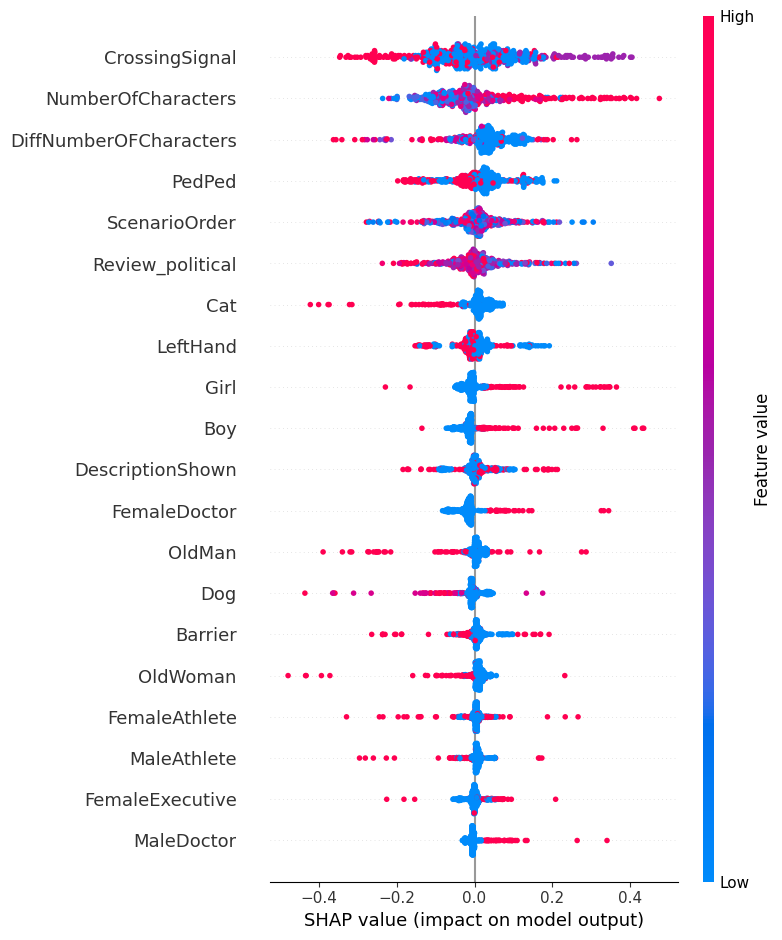

In [9]:
import shap
# decision tree
from sklearn.tree import DecisionTreeClassifier



df_x_combined = df_combined.iloc[:, 3:-2]
df_y_combined = df_combined['Saved']
df_x_combined = df_x_combined.drop(['Saved'], axis=1)
df_x_combined = df_x_combined.apply(lambda x: pd.to_numeric(x, errors='coerce'))

# deal with inf and -inf
df_x_combined = df_x_combined.replace([float('inf'), float('-inf')], float('nan'))

# deal with too large values
df_x_combined = df_x_combined.apply(lambda x: x.clip(lower=-1e10, upper=1e10))
df_x_combined = df_x_combined.dropna(axis=1)

x_train_combined, x_test_combined, y_train_combined, y_test_combined = train_test_split(df_x_combined, df_y_combined, test_size=0.2, random_state=0)

model_combined = DecisionTreeClassifier()
model_combined.fit(x_train_combined, y_train_combined)

# print classification report
y_pred_combined = model_combined.predict(x_test_combined)
print('Decision Tree')
print(accuracy_score(y_test_combined, y_pred_combined))
print(classification_report(y_test_combined, y_pred_combined))

# Create a SHAP explainer

explainer = shap.Explainer(model_combined, x_train_combined)

# Calculate SHAP values
shap_values = explainer(x_test_combined, check_additivity=False)

# print(type(shap_values))
# print(shap_values.shape)

# print(type(x_test_combined))
# print(x_test_combined.shape)
shap_values_positive_class = shap_values.values[...,1]

# Now you can plot the summary plot for the positive class
shap.summary_plot(shap_values_positive_class, x_test_combined)
# shap.summary_plot(shap_values, x_test_combined)

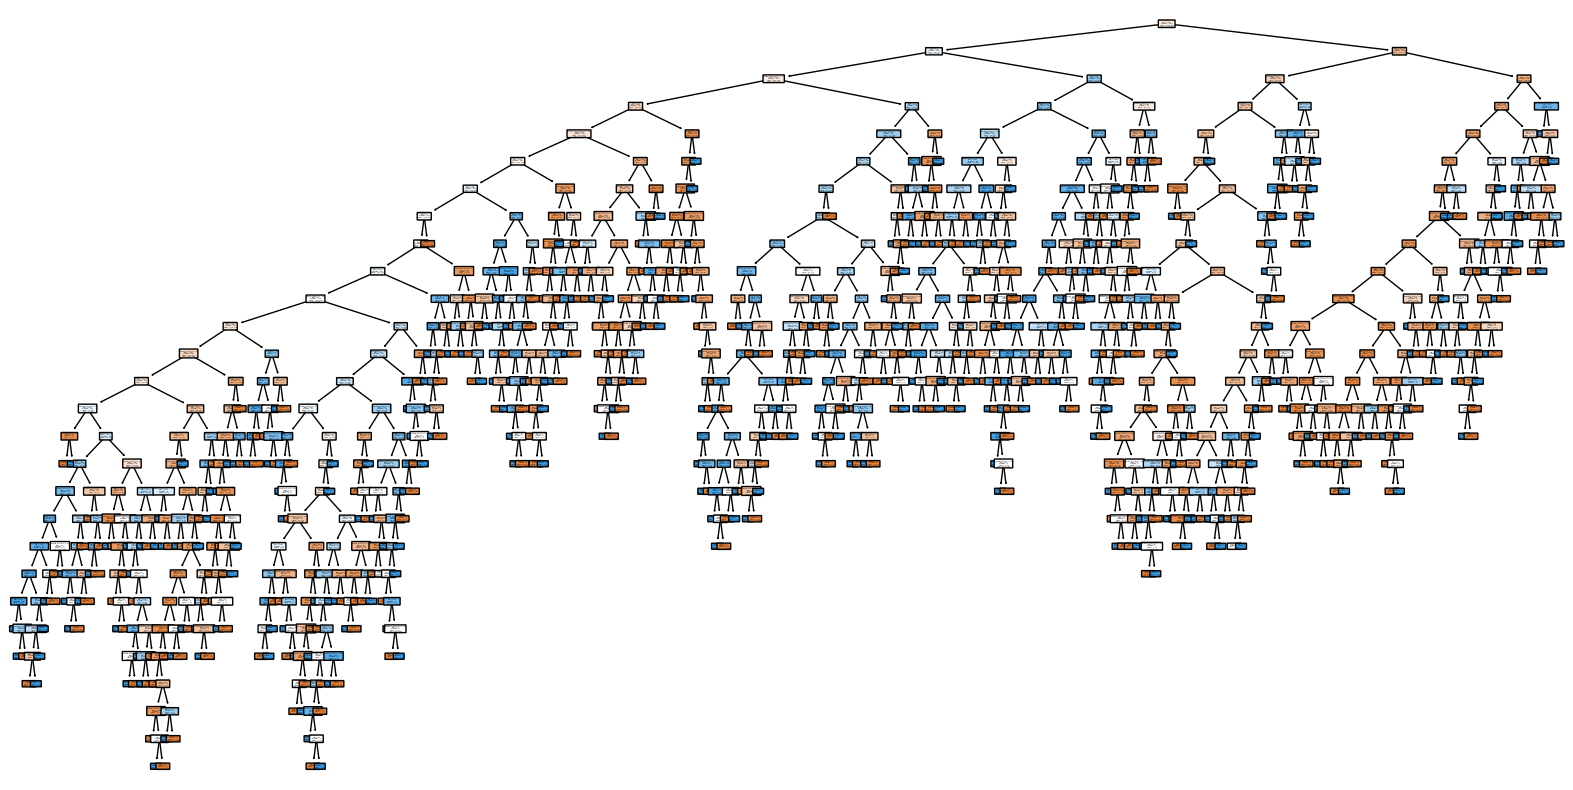

In [12]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(20,10))
plot_tree(model_combined, filled=True, rounded=True, class_names=['Not Saved', 'Saved'], feature_names=df_x_combined.columns)
plt.show()

In [13]:
from sklearn.tree import export_text

tree_rules = export_text(model_combined, feature_names=list(df_x_combined.columns))
print(tree_rules)

|--- CrossingSignal <= 1.50
|   |--- CrossingSignal <= 0.50
|   |   |--- NumberOfCharacters <= 4.50
|   |   |   |--- Cat <= 0.50
|   |   |   |   |--- DiffNumberOFCharacters <= 0.50
|   |   |   |   |   |--- OldMan <= 0.50
|   |   |   |   |   |   |--- Girl <= 0.50
|   |   |   |   |   |   |   |--- OldWoman <= 1.50
|   |   |   |   |   |   |   |   |--- Dog <= 0.50
|   |   |   |   |   |   |   |   |   |--- MaleDoctor <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- DescriptionShown <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 17
|   |   |   |   |   |   |   |   |   |   |--- DescriptionShown >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 17
|   |   |   |   |   |   |   |   |   |--- MaleDoctor >  0.50
|   |   |   |   |   |   |   |   |   |   |--- ScenarioOrder <= 12.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 5
|   |   |   |   |   |   |   |   |   |   |--- ScenarioOrder >  12.50
|   |   |

In [14]:
feature_importances = pd.DataFrame(model_combined.feature_importances_,
                                   index=df_x_combined.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

                        importance
Review_political          0.136412
ScenarioOrder             0.135277
NumberOfCharacters        0.094369
CrossingSignal            0.057910
DiffNumberOFCharacters    0.040776
Man                       0.038812
OldMan                    0.036516
LeftHand                  0.034006
Cat                       0.030649
OldWoman                  0.028442
FemaleAthlete             0.027355
PedPed                    0.027242
LargeMan                  0.026556
MaleAthlete               0.026022
Woman                     0.026018
Dog                       0.024340
Girl                      0.024046
Boy                       0.021483
DescriptionShown          0.021148
MaleExecutive             0.020718
Barrier                   0.018667
Homeless                  0.016300
FemaleExecutive           0.016178
LargeWoman                0.015400
MaleDoctor                0.014903
FemaleDoctor              0.012566
Pregnant                  0.010568
Stroller            

Decision Tree
0.5943204868154158
              precision    recall  f1-score   support

           0       0.62      0.63      0.62       262
           1       0.57      0.55      0.56       231

    accuracy                           0.59       493
   macro avg       0.59      0.59      0.59       493
weighted avg       0.59      0.59      0.59       493



No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


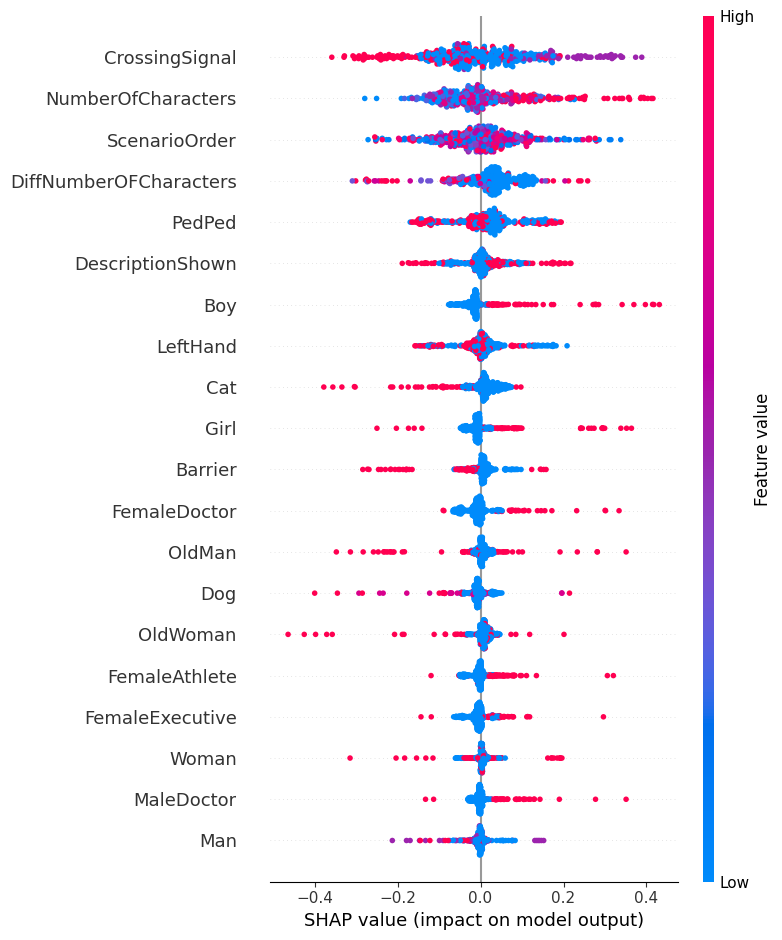

In [15]:
import shap
# decision tree
from sklearn.tree import DecisionTreeClassifier



df_x_combined = df_combined.iloc[:, 3:-3]
df_y_combined = df_combined['Saved']
df_x_combined = df_x_combined.drop(['Saved'], axis=1)
df_x_combined = df_x_combined.apply(lambda x: pd.to_numeric(x, errors='coerce'))

# deal with inf and -inf
df_x_combined = df_x_combined.replace([float('inf'), float('-inf')], float('nan'))

# deal with too large values
df_x_combined = df_x_combined.apply(lambda x: x.clip(lower=-1e10, upper=1e10))
df_x_combined = df_x_combined.dropna(axis=1)

x_train_combined, x_test_combined, y_train_combined, y_test_combined = train_test_split(df_x_combined, df_y_combined, test_size=0.2, random_state=0)

model_combined = DecisionTreeClassifier()
model_combined.fit(x_train_combined, y_train_combined)

# print classification report
y_pred_combined = model_combined.predict(x_test_combined)
print('Decision Tree')
print(accuracy_score(y_test_combined, y_pred_combined))
print(classification_report(y_test_combined, y_pred_combined))

# Create a SHAP explainer

explainer = shap.Explainer(model_combined, x_train_combined)

# Calculate SHAP values
shap_values = explainer(x_test_combined, check_additivity=False)

# print(type(shap_values))
# print(shap_values.shape)

# print(type(x_test_combined))
# print(x_test_combined.shape)
shap_values_positive_class = shap_values.values[...,1]

# Now you can plot the summary plot for the positive class
shap.summary_plot(shap_values_positive_class, x_test_combined)

Random Forest
0.7272727272727273
              precision    recall  f1-score   support

           0       0.73      0.77      0.75       219
           1       0.73      0.68      0.70       199

    accuracy                           0.73       418
   macro avg       0.73      0.73      0.73       418
weighted avg       0.73      0.73      0.73       418



 96%|=================== | 799/836 [00:23<00:01]       No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


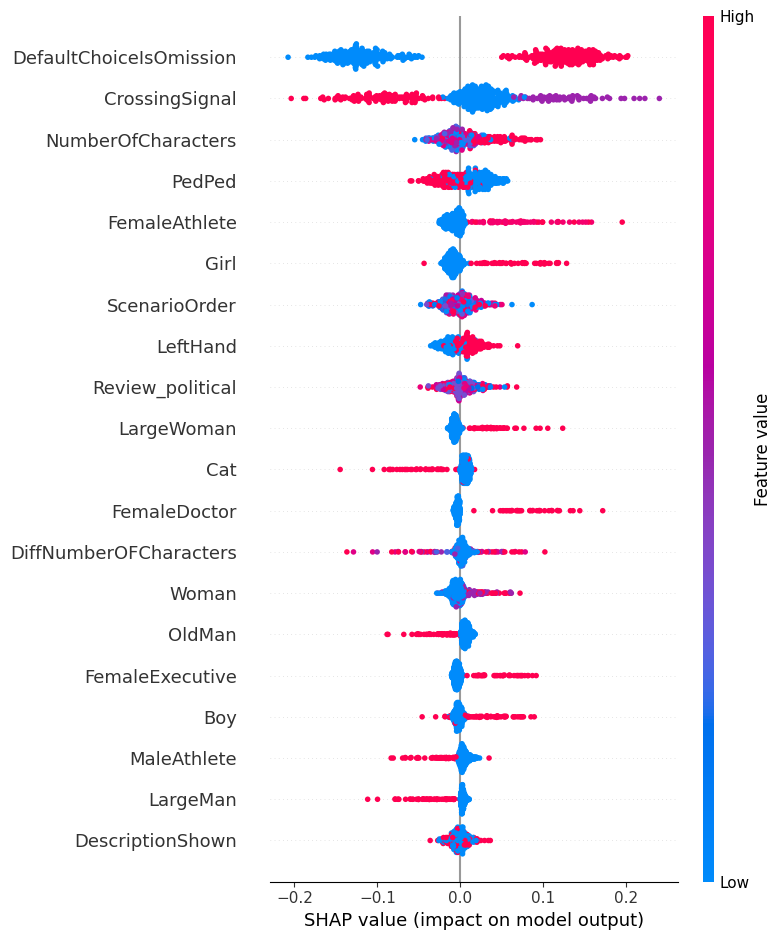

In [4]:
import shap

df_x_combined = df_combined.iloc[:, 3:-2]
df_y_combined = df_combined['Saved']
df_x_combined = df_x_combined.drop(['Saved'], axis=1)
df_x_combined = df_x_combined.apply(lambda x: pd.to_numeric(x, errors='coerce'))

# deal with inf and -inf
df_x_combined = df_x_combined.replace([float('inf'), float('-inf')], float('nan'))

# deal with too large values
df_x_combined = df_x_combined.apply(lambda x: x.clip(lower=-1e10, upper=1e10))
df_x_combined = df_x_combined.dropna(axis=1)

x_train_combined, x_test_combined, y_train_combined, y_test_combined = train_test_split(df_x_combined, df_y_combined, test_size=0.2, random_state=0)

model_combined = RandomForestClassifier()
model_combined.fit(x_train_combined, y_train_combined)

# print classification report
y_pred_combined = model_combined.predict(x_test_combined)
print('Random Forest')
print(accuracy_score(y_test_combined, y_pred_combined))
print(classification_report(y_test_combined, y_pred_combined))

# Create a SHAP explainer

explainer = shap.Explainer(model_combined, x_train_combined)

# Calculate SHAP values
shap_values = explainer(x_test_combined, check_additivity=False)

# print(type(shap_values))
# print(shap_values.shape)

# print(type(x_test_combined))
# print(x_test_combined.shape)
shap_values_positive_class = shap_values.values[...,1]

# Now you can plot the summary plot for the positive class
shap.summary_plot(shap_values_positive_class, x_test_combined)
# shap.summary_plot(shap_values, x_test_combined)

Random Forest
0.715311004784689
              precision    recall  f1-score   support

           0       0.71      0.76      0.74       219
           1       0.72      0.66      0.69       199

    accuracy                           0.72       418
   macro avg       0.72      0.71      0.71       418
weighted avg       0.72      0.72      0.71       418



100%|===================| 834/836 [00:29<00:00]        No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


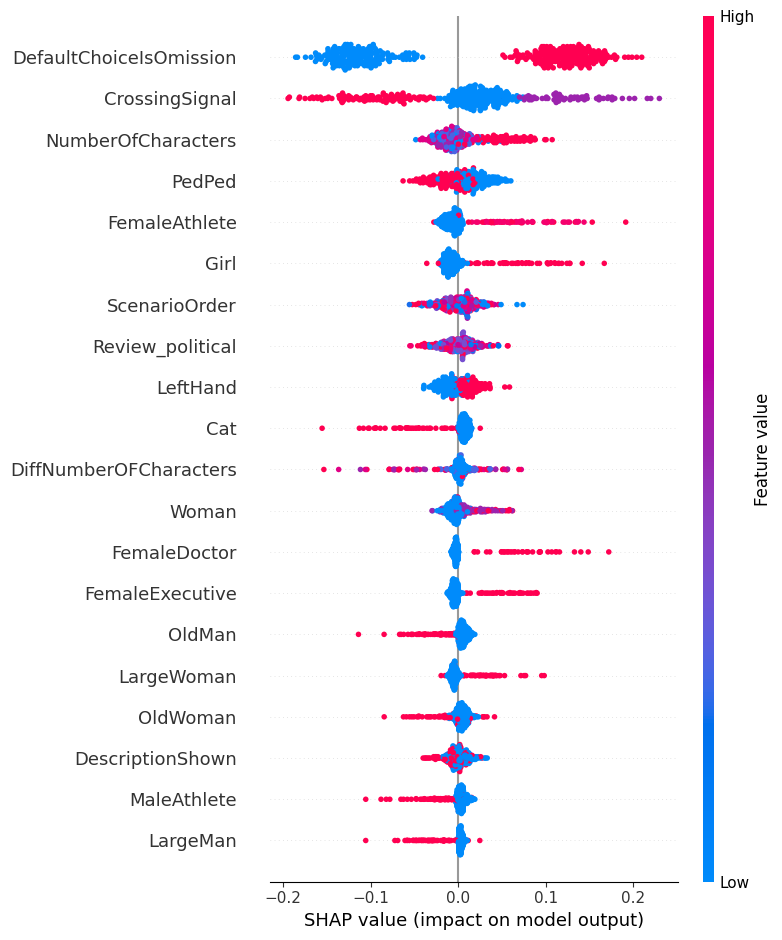

In [19]:
import shap

df_x_combined = df_combined.iloc[:, 3:-2]
df_y_combined = df_combined['Saved']
df_x_combined = df_x_combined.drop(['Saved'], axis=1)
df_x_combined = df_x_combined.apply(lambda x: pd.to_numeric(x, errors='coerce'))

# deal with inf and -inf
df_x_combined = df_x_combined.replace([float('inf'), float('-inf')], float('nan'))

# deal with too large values
df_x_combined = df_x_combined.apply(lambda x: x.clip(lower=-1e10, upper=1e10))
df_x_combined = df_x_combined.dropna(axis=1)

x_train_combined, x_test_combined, y_train_combined, y_test_combined = train_test_split(df_x_combined, df_y_combined, test_size=0.2, random_state=0)

model_combined = RandomForestClassifier()
model_combined.fit(x_train_combined, y_train_combined)

# print classification report
y_pred_combined = model_combined.predict(x_test_combined)
print('Random Forest')
print(accuracy_score(y_test_combined, y_pred_combined))
print(classification_report(y_test_combined, y_pred_combined))

# Create a SHAP explainer

explainer = shap.Explainer(model_combined, x_train_combined)

# Calculate SHAP values
shap_values = explainer(x_test_combined, check_additivity=False)

# print(type(shap_values))
# print(shap_values.shape)

# print(type(x_test_combined))
# print(x_test_combined.shape)
shap_values_positive_class = shap_values.values[...,1]

# Now you can plot the summary plot for the positive class
shap.summary_plot(shap_values_positive_class, x_test_combined)
# shap.summary_plot(shap_values, x_test_combined)

Random Forest
0.7248803827751196
              precision    recall  f1-score   support

           0       0.72      0.77      0.75       219
           1       0.73      0.68      0.70       199

    accuracy                           0.72       418
   macro avg       0.72      0.72      0.72       418
weighted avg       0.72      0.72      0.72       418



100%|===================| 834/836 [00:19<00:00]        No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


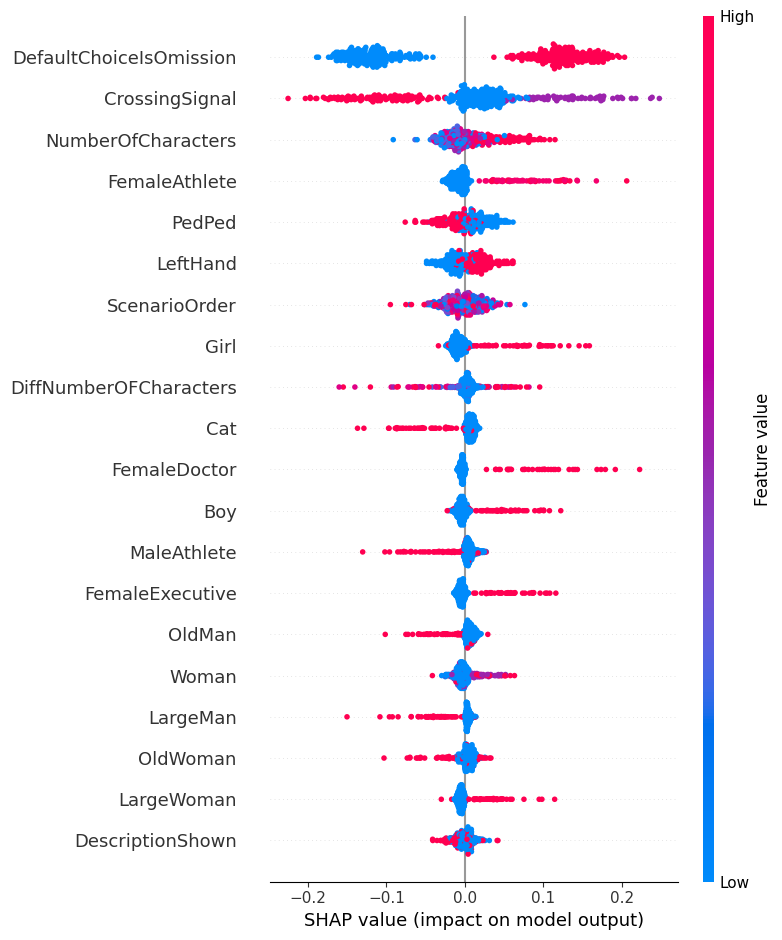

In [5]:
# drop column Review_political
df_x_combined = df_combined.iloc[:, 3:-3]
df_y_combined = df_x_combined['Saved']
df_x_combined = df_x_combined.drop(['Saved'], axis=1)
df_x_combined = df_x_combined.apply(lambda x: pd.to_numeric(x, errors='coerce'))

# deal with inf and -inf
df_x_combined = df_x_combined.replace([float('inf'), float('-inf')], float('nan'))

# deal with too large values
df_x_combined = df_x_combined.apply(lambda x: x.clip(lower=-1e10, upper=1e10))
df_x_combined = df_x_combined.dropna(axis=1)


x_train_combined, x_test_combined, y_train_combined, y_test_combined = train_test_split(df_x_combined, df_y_combined, test_size=0.2, random_state=0)

model_combined = RandomForestClassifier()
model_combined.fit(x_train_combined, y_train_combined)

y_pred_combined = model_combined.predict(x_test_combined)
print('Random Forest')
print(accuracy_score(y_test_combined, y_pred_combined))
print(classification_report(y_test_combined, y_pred_combined))

# Create a SHAP explainer

explainer = shap.Explainer(model_combined, x_train_combined)

# Calculate SHAP values
shap_values = explainer(x_test_combined, check_additivity=False)

# print(type(shap_values))
# print(shap_values.shape)

# print(type(x_test_combined))
# print(x_test_combined.shape)
shap_values_positive_class = shap_values.values[...,1]

# Now you can plot the summary plot for the positive class
shap.summary_plot(shap_values_positive_class, x_test_combined)
# shap.summary_plot(shap_values, x_test_combined)

In [18]:
from sklearn.model_selection import cross_val_score, KFold
import numpy as np

df_x_combined = df_combined.iloc[:, 3:-2]
df_y_combined = df_combined['Saved']
df_x_combined = df_x_combined.drop(['Saved'], axis=1)
df_x_combined = df_x_combined.apply(lambda x: pd.to_numeric(x, errors='coerce'))

# deal with inf and -inf
df_x_combined = df_x_combined.replace([float('inf'), float('-inf')], float('nan'))

# deal with too large values
df_x_combined = df_x_combined.apply(lambda x: x.clip(lower=-1e10, upper=1e10))
df_x_combined = df_x_combined.dropna(axis=1)
df_x_without_review_political = df_x_combined.drop(['Review_political'], axis=1, errors='ignore')  # errors='ignore' allows smooth execution even if the column is absent

# Define the cross-validation strategy
kf = KFold(n_splits=5, shuffle=True, random_state=0)

# Initialize the model
model_rf = RandomForestClassifier(random_state=0)

# Perform cross-validation for the dataset WITH "Review_political"
scores_with = cross_val_score(model_rf, df_x_combined, df_y_combined, cv=kf, scoring='accuracy')

# Perform cross-validation for the dataset WITHOUT "Review_political"
scores_without = cross_val_score(model_rf, df_x_without_review_political, df_y_combined, cv=kf, scoring='accuracy')

# Calculate and print the average accuracy
print(f"Average accuracy WITH 'Review_political': {np.mean(scores_with):.4f} ± {np.std(scores_with):.4f}")
print(f"Average accuracy WITHOUT 'Review_political': {np.mean(scores_without):.4f} ± {np.std(scores_without):.4f}")


Average accuracy WITH 'Review_political': 0.7114 ± 0.0233
Average accuracy WITHOUT 'Review_political': 0.6956 ± 0.0179


In [6]:
df_x_combined.head()

,ScenarioOrder,Intervention,PedPed,Barrier,CrossingSignal,NumberOfCharacters,DiffNumberOFCharacters,DescriptionShown,LeftHand,Man,...,Criminal,MaleExecutive,FemaleExecutive,FemaleAthlete,MaleAthlete,FemaleDoctor,MaleDoctor,Dog,Cat,Review_political
0,11,0,1,0,2,4,1,0,1,0,...,0,0,0,1,0,0,0,0,0,0.88
1,6,0,1,0,0,5,0,1,0,0,...,0,0,0,0,0,0,0,3,2,0.16
2,10,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0.86
3,9,0,1,0,0,3,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1.00
4,12,0,0,0,0,5,0,1,0,2,...,0,0,0,0,0,0,0,0,0,0.93


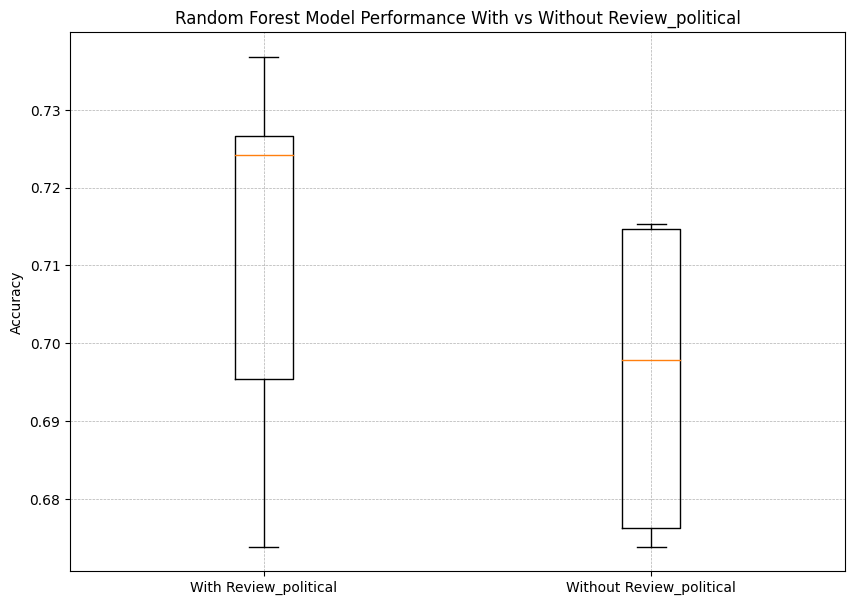

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))  # Adjust the figure size as needed
plt.boxplot([scores_with, scores_without], labels=['With Review_political', 'Without Review_political'])
plt.title('Random Forest Model Performance With vs Without Review_political')  # Title of the boxplot
plt.ylabel('Accuracy')  # Label for the y-axis
plt.grid(True, which='both', linestyle='--', linewidth=0.5)  # Adding a grid for better readability
plt.show()  # Display the plot

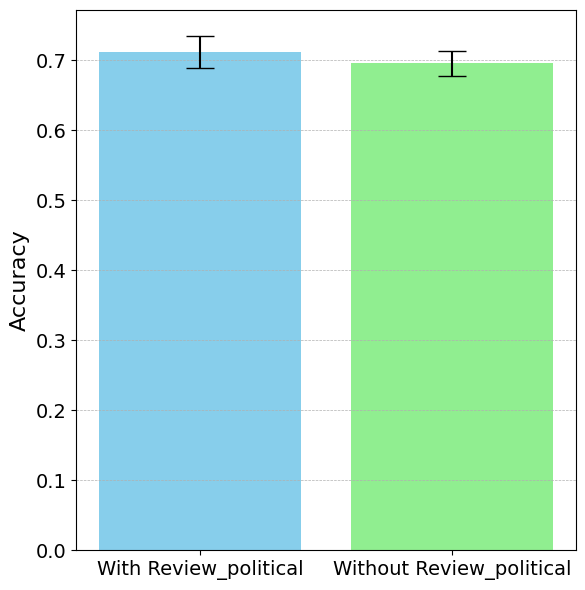

In [31]:
# graph the mean of the accuracy
plt.figure(figsize=(6, 6))  # Making the figure larger for better visibility
plt.bar(['With Review_political', 'Without Review_political'], [np.mean(scores_with), np.mean(scores_without)], 
        yerr=[np.std(scores_with), np.std(scores_without)], capsize=10, color=['skyblue', 'lightgreen'])
# plt.title('Random Forest Model Performance With vs Without Review_political', fontsize=18)  # Increased fontsize
plt.ylabel('Accuracy', fontsize=16)  # Increased fontsize
plt.xticks(fontsize=14)  # Increase x-axis tick label fontsize
plt.yticks(fontsize=14)  # Increase y-axis tick label fontsize
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()  # Adjust layout to make room for the larger text
# plt.show()
plt.savefig('report_graph/accuracy_with_without_review_political.png')

In [ ]:
# # graph the mean of the accuracy
# plt.figure(figsize=(10, 7))
# plt.bar(['With Review_political', 'Without Review_political'], [np.mean(scores_with), np.mean(scores_without)], yerr=[np.std(scores_with), np.std(scores_without)], capsize=10)
# plt.title('Random Forest Model Performance With vs Without Review_political')
# plt.ylabel('Accuracy')
# plt.grid(axis='y', linestyle='--', linewidth=0.5)
# plt.show()

# plot with s

In [8]:
from scipy.stats import shapiro, ttest_ind, mannwhitneyu

# Step 1: Normality Test
_, p_value_with = shapiro(scores_with)
_, p_value_without = shapiro(scores_without)

# Use alpha=0.05 to test for normality
alpha = 0.05
if p_value_with < alpha or p_value_without < alpha:
    print("At least one of the groups does not follow a normal distribution. Proceeding with Mann-Whitney U test.")
    # Step 2A: Mann-Whitney U test for non-normal distributions
    stat, p = mannwhitneyu(scores_with, scores_without)
else:
    print("Both groups follow a normal distribution. Proceeding with t-test.")
    # Step 2B: T-test for independent samples for normal distributions
    stat, p = ttest_ind(scores_with, scores_without)

# Print the result
if p < alpha:
    print(f"Statistically significant difference found (p = {p:.4f}).")
else:
    print(f"No statistically significant difference found (p = {p:.4f}).")

Both groups follow a normal distribution. Proceeding with t-test.
No statistically significant difference found (p = 0.3127).
